## bus proyect 

modules import

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline
from math import sin, cos, sqrt, atan2, radians
pd.set_option('precision', 2)
from functools import reduce
import os
from operator import truediv


Populating the interactive namespace from numpy and matplotlib


constants definition

In [2]:
#range of hours considered
lower_limit_time_range=1200
upper_limit_time_range=1400
line_frequency_bound=10
T = 120
quantile_freq = 0.1
bus_capacity = 5

load of data from files

In [3]:
# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
bus_schedules_by_stops = pd.read_csv('files/uptu_pasada_variante.csv',sep=';')

# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
uptu_pasada_circular = pd.read_csv('files/uptu_pasada_circular.csv',sep=';')

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
stops_ubication = gpd.read_file('files/v_uptu_paradas.shx')
stops_ubication = pd.DataFrame(stops_ubication)

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
recorridos_omnibus = gpd.read_file('files/v_uptu_lsv.dbf')
recorridos_omnibus = pd.DataFrame(recorridos_omnibus)

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
ubicacion_puntos_control = gpd.read_file('files/v_uptu_controles.dbf')
ubicacion_puntos_control = pd.DataFrame(ubicacion_puntos_control)

# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
origen_destino_lineas = gpd.read_file('files/v_uptu_lsv_destinos.dbf')
origen_destino_lineas = pd.DataFrame(origen_destino_lineas)

# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
recorridos_variantes_no_maximales = gpd.read_file('files/uptu_variante_no_maximal.dbf')
recorridos_variantes_no_maximales = pd.DataFrame(recorridos_variantes_no_maximales)


#recorridos_omnibus.query('COD_VARIAN == 1303')
recorridos_variantes_no_maximales.query('COD_VARIAN == 1303')
#recorridos_omnibus
#recorridos_variantes_no_maximales

recorridos_omnibus.query('COD_VARIAN == 1303')

bus_schedules_by_stops
uptu_pasada_circular

recorridos_variantes_no_maximales
origen_destino_lineas.query('COD_VARIAN == 1276')



,GID,COD_LINEA,DESC_LINEA,ORDINAL_SU,COD_SUBLIN,DESC_SUBLI,COD_VARIAN,DESC_VARIA,COD_VAR_01,COD_ORIGEN,DESC_ORIGE,COD_DESTIN,DESC_DESTI,geometry
794,4.62e+07,85,181,1,165,POCITOS - ESC. MARITIMA,1276,B,1274.0,24,POCITOS,67,PASO MOLINO,None


demand for defined period

In [4]:
# TODO: pedir a Renzo el calculo de esto

file_name='files/trasbordos.csv'
transfers = pd.read_csv(file_name,sep=',')
transfers.columns = ['stop_id_1','stop_id_2','line_id_1','line_id_2','n_transfers']
transfers_all_day = transfers

file_name='files/trasbordos_' + str(lower_limit_time_range) + '_' + str(upper_limit_time_range) +'.csv'
transfers = pd.read_csv(file_name,sep=',')
transfers.columns = ['stop_id_1','stop_id_2','line_id_1','line_id_2','n_transfers']
transfers_1200_1400 = transfers

file_name='files/trasbordos_1200_1400_200.csv'
transfers = pd.read_csv(file_name,sep=',')
transfers.columns = ['stop_id_1','stop_id_2','line_id_1','line_id_2','n_transfers']
trasbordos_1200_1400_200 = transfers




#display(transfers_all_day.head())
#display(trasbordos_1200_1400_200.head(50))





### start  proccesing

output file structure

4 3 120 //lines sync_points period

1 2 2 100 3 10 15 16 0 // line1 line2 dist demand wb Wb TTl1 TTl2 bach

2 3 1  50 5  8 18 22 0

3 4 1  75 5  8 18 22 0

5 15

4 12

4 10

4 10


lines with low frecuency

In [5]:
valid_lines_list = bus_schedules_by_stops.query('ordinal==1').copy()
valid_lines_list['count'] = 1
valid_lines_list = valid_lines_list.groupby('cod_variante').sum().reset_index()
valid_lines_list=valid_lines_list[valid_lines_list['count'] > line_frequency_bound]['cod_variante']


filtering lines with low frecuency in bus stops

In [6]:
bus_schedules_by_stops = bus_schedules_by_stops[bus_schedules_by_stops['cod_variante']
                                                .isin(valid_lines_list)] 


merge transfers with no maximal lines

In [7]:
#display(recorridos_variantes_no_maximales.head())

def complete_maximals(transfers):
    transfers_with_no_max = transfers.copy()
    transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                     how='left', left_on=['line_id_1'], right_on=['COD_VARIAN'])
    transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'COD_VAR_01',]]
    transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'line_id_1_var_01',]

    transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                     how='left', left_on=['line_id_2'], right_on=['COD_VARIAN'])

    transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers','line_id_1_var_01',
                                                  'COD_VAR_01',]]
    transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'line_id_1_var_01','line_id_2_var_01',]

    transfers_with_no_max['line_id_1_var_01'] =\
                transfers_with_no_max.apply(lambda e: e.line_id_1 
                                            if math.isnan(e.line_id_1_var_01)
                                            else e.line_id_1_var_01,axis = 1) 

    transfers_with_no_max['line_id_2_var_01'] =\
                transfers_with_no_max.apply(lambda e: e.line_id_2 
                                            if math.isnan(e.line_id_2_var_01) 
                                            else e.line_id_2_var_01,axis = 1)
    return transfers_with_no_max

#display(transfers_all_day.head(1))
#display(transfers_1200_1400_with_max.head(1))

transfers_all_day_with_max = complete_maximals(transfers_all_day)
transfers_1200_1400_with_max = complete_maximals(transfers_1200_1400)
transfers_1200_1400_with_max_200 = complete_maximals(trasbordos_1200_1400_200)



display(transfers_all_day_with_max.head(1))
display(transfers_1200_1400_with_max.head(1))
display(transfers_1200_1400_with_max_200.head(1))


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,2427,2426,1096,2579,309,1096.0,1311.0


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,1942.0,4848,1759,2422,31,1759.0,1736.0


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,1942.0,4848,1759,2422,31,1759.0,1736.0


filtering valid transfers, according to its lines frequency

In [8]:
def filter_transfers(transfers_with_max):
    transfers_with_max = transfers_with_max[transfers_with_max['line_id_1'].isin(valid_lines_list)] 
    transfers_with_max = transfers_with_max[transfers_with_max['line_id_2'].isin(valid_lines_list)]
    return transfers_with_max

transfers_all_day_with_max = filter_transfers(transfers_all_day_with_max)
transfers_1200_1400_with_max = filter_transfers(transfers_1200_1400_with_max)
transfers_1200_1400_with_max_200 = filter_transfers(transfers_1200_1400_with_max_200)




display(transfers_all_day_with_max.head(1))
display(transfers_1200_1400_with_max.head(1))
display(transfers_1200_1400_with_max_200.head(1))

,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,2427,2426,1096,2579,309,1096.0,1311.0


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,1942.0,4848,1759,2422,31,1759.0,1736.0


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01
0,1942.0,4848,1759,2422,31,1759.0,1736.0


calculate tt

In [9]:
#time1-time2
def diff(time1,time2):
    hours1 = time1 // 100
    minutes1 = time1 % 100
    hours2 = time2 // 100
    minutes2 = time2 % 100
    minutos_desde_la_cero_hora1=hours1*60+minutes1
    minutos_desde_la_cero_hora2=hours2*60+minutes2
    return minutos_desde_la_cero_hora2 - minutos_desde_la_cero_hora1

def ttaux(frecuencia,bus_in):
    bus=bus_in.copy()
    bus=bus[bus.ordinal == 1]
    bus=bus[bus['frecuencia'] ==  frecuencia]
    bus=bus[bus['tipo_dia'] ==  1]
    bus=bus[bus['dia_anterior'] ==  'N']
    #bus=bus
    #display(bus)
    #display(bus)
    return bus['hora'].iloc[0].copy()


def tt(linea,parada,bus_schedules_by_stops):

    #linea=170
    #parada=4212
    #display(linea)
    #display(parada)
    query='cod_variante=='+ str(linea)# +' and cod_ubic_parada == '+str(parada)
    bus_schedules_by_stops_aux = bus_schedules_by_stops.query(query).copy()
    aux1=bus_schedules_by_stops_aux.copy()
    
    query='cod_variante=='+ str(linea) +' and cod_ubic_parada == '+str(parada)
    aux2 = bus_schedules_by_stops.query(query).copy()
    
    #display(aux2)
    
    aux2 = aux2.query('tipo_dia == 1').copy()
       
    frecuencias_validas_horarios= aux1.query('tipo_dia == 1 and ordinal==1 and hora >=' +
                                             str(lower_limit_time_range-400) +
                                            'and hora <= ' + str(upper_limit_time_range+400)
                                            )
    
    aux1 = aux1[aux1['frecuencia'].isin(frecuencias_validas_horarios['frecuencia'])]
    aux2 = aux2[aux2['frecuencia'].isin(frecuencias_validas_horarios['frecuencia'])]
    #aux2 = aux2.query('frecuencia == 7070')
    
    if (aux2.size>0):
        
        #display(aux2)
        aux2['hora_salida'] =\
        aux2.apply(lambda e: ttaux(e.frecuencia,aux1),axis = 1) 

        #display(aux2)
        aux2['TT'] =\
            aux2.apply(lambda e: diff(e.hora_salida,e.hora),axis = 1) 
        aux2 =\
        aux2.groupby(['tipo_dia','cod_variante','cod_ubic_parada']).mean().reset_index()


        #display(aux2)
        query='cod_variante=='+ str(linea) +' and cod_ubic_parada == '+str(parada)#+' and tipo_dia == 1 '
        
        aaa= aux2.query(query)['TT']
        
#        print(aaa)
        return aaa
    else:
        return -1

def add_tt1_tt2(transfers_with_no_max):        
    transfers_with_no_max2 = transfers_with_no_max#[transfers_with_no_max['line_id_1'] ==  170].copy()
    transfers_with_no_max2['TT1'] =\
            transfers_with_no_max2.apply(lambda e: tt(e.line_id_1_var_01,e.stop_id_1,bus_schedules_by_stops),axis = 1).copy() 
    transfers_with_no_max2['TT2'] =\
            transfers_with_no_max2.apply(lambda e: tt(e.line_id_2_var_01,e.stop_id_2,bus_schedules_by_stops),axis = 1).copy() 
    transfers_with_no_max2 = transfers_with_no_max2.query('TT1 >= 0 and TT2 >= 0')
    return transfers_with_no_max2

transfers_all_day_max_tts = add_tt1_tt2(transfers_all_day_with_max)
transfers_1200_1400_max_tts = add_tt1_tt2(transfers_1200_1400_with_max)
transfers_1200_1400_max_tts_200 = add_tt1_tt2(transfers_1200_1400_with_max_200)


display(transfers_all_day_max_tts.head(50))
display(transfers_1200_1400_max_tts.head(50))
display(transfers_1200_1400_max_tts_200.head(50))  

#transfers_1200_1400_max_tts_coors_200.query('line_id_1 == 2070')
    
    

/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01,TT1,TT2
0,2427,2426,1096,2579,309,1096.0,1311.0,23.12,21.78
1,1885,4468,1759,1667,204,1759.0,1667.0,18.33,0.00
2,1108,4775,1122,650,186,1122.0,650.0,20.62,15.35
3,1942,4399,1759,987,165,1759.0,982.0,26.33,12.00
4,4212,5709,170,2579,149,170.0,1311.0,21.75,12.00
5,2447,2437,1276,1092,148,1274.0,1092.0,50.50,37.75
7,2427,2426,1096,1290,136,1096.0,1282.0,23.12,23.80
9,4843,4930,1122,1347,128,1122.0,1347.0,22.62,17.13


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01,TT1,TT2
1,4212.0,5709,170,1290,30,170.0,1282.0,21.75,[12.0]
2,2392.0,2295,2050,1418,30,2050.0,1418.0,8.13,[2.0]
3,4135.0,4135,1117,170,28,1117.0,170.0,84.56,[0.0]
4,4212.0,5709,2411,1290,25,708.0,1282.0,50.67,[12.0]
6,2427.0,2426,1096,1290,25,1096.0,1282.0,23.12,[23.8]
9,2392.0,2295,2050,540,23,2050.0,522.0,8.13,[25.0833333333]
10,2447.0,2437,1276,1092,23,1274.0,1092.0,50.50,[37.746031746]
11,4925.0,4930,1580,1347,23,1580.0,1347.0,10.00,[17.1343283582]
12,1108.0,4775,1122,650,22,1122.0,650.0,20.62,[15.3521126761]
13,1858.0,1858,969,1758,21,968.0,1758.0,67.18,[0.0]


,stop_id_1,stop_id_2,line_id_1,line_id_2,n_transfers,line_id_1_var_01,line_id_2_var_01,TT1,TT2
1,4212.0,5709,170,1290,30,170.0,1282.0,21.75,[12.0]
2,2392.0,2295,2050,1418,30,2050.0,1418.0,8.13,[2.0]
3,4135.0,4135,1117,170,28,1117.0,170.0,84.56,[0.0]
4,4212.0,5709,2411,1290,25,708.0,1282.0,50.67,[12.0]
6,2427.0,2426,1096,1290,25,1096.0,1282.0,23.12,[23.8]
9,2392.0,2295,2050,540,23,2050.0,522.0,8.13,[25.0833333333]
10,2447.0,2437,1276,1092,23,1274.0,1092.0,50.50,[37.746031746]
11,4925.0,4930,1580,1347,23,1580.0,1347.0,10.00,[17.1343283582]
12,1108.0,4775,1122,650,22,1122.0,650.0,20.62,[15.3521126761]
13,1858.0,1858,969,1758,21,968.0,1758.0,67.18,[0.0]


merge transfers and stops ubication to get stops geometriy (coordinates)

In [10]:
def add_sptop_coors(transfers_with_no_max):    
    transfers_with_stop_coors = transfers_with_no_max.copy()
    transfers_with_stop_coors =  pd.merge(transfers_with_stop_coors, stops_ubication, 
                     how='left', left_on=['stop_id_1','line_id_1_var_01'], right_on=['COD_UBIC_P',
                                                                                     'COD_VARIAN'])
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                           'stop_id_2','line_id_1_var_01',
                                                             'line_id_2_var_01','n_transfers','geometry','TT1','TT2']]
    transfers_with_stop_coors.columns = ['line_id_1','line_id_2','stop_id_1','stop_id_2',
                                         'line_id_1_var_01','line_id_2_var_01','n_transfers',
                                          'line_1_geometry','TT1','TT2']
    transfers_with_stop_coors = pd.merge(transfers_with_stop_coors, stops_ubication, 
                     how='left', left_on=['stop_id_2','line_id_2_var_01'], right_on=['COD_UBIC_P',
                                                                                     'COD_VARIAN'])
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                           'stop_id_2','line_id_1_var_01',
                                                             'line_id_2_var_01','n_transfers',
                                                           'line_1_geometry','geometry','TT1','TT2']]
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1',
                                                             'line_id_2','n_transfers',
                                                             'line_1_geometry',
                                                             'geometry','TT1','TT2']]
    transfers_with_stop_coors.columns = ['line_id_1',
                                        'line_id_2','n_transfers','line_1_geometry',
                                        'line_2_geometry','TT1','TT2']
    return transfers_with_stop_coors

transfers_all_day_max_tts_coors = add_sptop_coors(transfers_all_day_max_tts)
transfers_1200_1400_max_tts_coors = add_sptop_coors(transfers_1200_1400_max_tts)
transfers_1200_1400_max_tts_coors_200 = add_sptop_coors(transfers_1200_1400_max_tts_200)

display(transfers_all_day_max_tts_coors.head(1))
display(transfers_1200_1400_max_tts_coors.head(1))
display(transfers_1200_1400_max_tts_coors_200.head(1))




,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2
0,1096,2579,309,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),23.12,21.78


,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2
0,170,1290,30,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),21.75,[12.0]


,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2
0,170,1290,30,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),21.75,[12.0]


caculate distance between stops of lines

In [11]:
def dist(geometry_1,geometry_2):
    return geometry_1.distance(geometry_2)

def add_dist(transfers_with_stop_coors):
    transfers_with_stop_coors['dist'] =\
    transfers_with_stop_coors.apply(lambda e:dist(e.line_1_geometry,e.line_2_geometry),axis = 1) 
    transfers_with_stop_coors.head(20)
    return transfers_with_stop_coors
    
transfers_all_day_max_tts_coors_dist = add_dist(transfers_all_day_max_tts_coors)
transfers_1200_1400_max_tts_coors_dist = add_dist(transfers_1200_1400_max_tts_coors)
transfers_1200_1400_max_tts_coors_dist_200 = add_dist(transfers_1200_1400_max_tts_coors_200)


display(transfers_all_day_max_tts_coors_dist.head(1))
display(transfers_1200_1400_max_tts_coors_dist.head(1))
display(transfers_1200_1400_max_tts_coors_dist_200.head(1))

,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2,dist
0,1096,2579,309,POINT (574358.64012 6142007.80678),POINT (574335.992349177 6142073.73086134),23.12,21.78,69.71


,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2,dist
0,170,1290,30,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),21.75,[12.0],107.06


,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2,dist
0,170,1290,30,POINT (571782.139845352 6142120.25843186),POINT (571879.0758399999 6142165.71392),21.75,[12.0],107.06


intersection points

In [12]:
def dist(transfers_with_stop_coors):
    points = transfers_with_stop_coors[['line_id_1','line_id_2','dist','n_transfers','TT1','TT2']]
    points.columns = ['line_i','line_j','dist','demand','TT_i','TT_j']
    points.insert(4, 'wb',5)
    points.insert(5, 'wB', 10)
    #points.insert(6, 'TT_i', np.zeros(len(points)))
    #points.insert(7, 'TT_j', np.zeros(len(points)))
    points.insert(8, 'BP', np.zeros(len(points)))
    return points

points_all_day = dist(transfers_all_day_max_tts_coors_dist)
points_1200_1400 = dist(transfers_1200_1400_max_tts_coors_dist)
points_1200_1400_200 = dist(transfers_1200_1400_max_tts_coors_dist_200)


display(points_all_day.head(1))
display(points_1200_1400.head(1))
display(points_1200_1400_200.head(1))



,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,1096,2579,69.71,309,5,10,23.12,21.78,0.0


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,170,1290,107.06,30,5,10,21.75,[12.0],0.0


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,170,1290,107.06,30,5,10,21.75,[12.0],0.0


frequency

justificar modelo de frecuencias constantes calculando promedio y desviacion respecto a frecuencias reales


In [13]:
def max_min_avg_line_frec( linea ,bus_schedules_by_stops,lower_limit_time_range,upper_limit_time_range):
    resultado=bus_schedules_by_stops.query('tipo_dia==1 and ordinal==1 and dia_anterior== "N" and cod_variante=='
                                           +str(linea)+
                                           ' and hora>='+str(lower_limit_time_range-400)+' and hora<='
                                           +str(upper_limit_time_range+400))
    
    
    #print(resultado.query('cod_variante == 1276')['hora'])
    

    resultadoHoraTolistSinRepetidos=list(set(resultado.hora.tolist()))
    resultadoHoraTolistSinRepetidos = sorted(resultadoHoraTolistSinRepetidos)
    cant_rows = len(resultadoHoraTolistSinRepetidos)
    
    maxima_fecuencia = 0
    minima_frecuencia = 10000000
    lista_frecuencias_minutos_linea=[]
    
    for i in range(cant_rows-1):
        time1=resultadoHoraTolistSinRepetidos[i]
        time2=resultadoHoraTolistSinRepetidos[i+1]
        hours1 = time1 // 100
        minutes1 = time1 % 100
        hours2 = time2 // 100
        minutes2 = time2 % 100
        minutos_desde_la_cero_hora1=hours1*60+minutes1
        minutos_desde_la_cero_hora2=hours2*60+minutes2
        resta = minutos_desde_la_cero_hora2-minutos_desde_la_cero_hora1
        lista_frecuencias_minutos_linea.append(resta)
        if(maxima_fecuencia<resta):
            maxima_fecuencia=resta
    #elimina los duplicados    
    lista_frecuencias_minutos_linea = list(set(lista_frecuencias_minutos_linea)) 
    

    
    
    retornero =	{
      "min": min(lista_frecuencias_minutos_linea),
      "max": maxima_fecuencia,
      "avg": sum(lista_frecuencias_minutos_linea)/len(lista_frecuencias_minutos_linea)
    }
    return retornero

def frequencies(points):

    lista_min = []
    lista_max = []
    lista_avg = []
    lineas_en_orden_procesado=[]



    # list of used stops
    aux_lines_i =  pd.DataFrame({'linea': points['line_i'] })
    aux_lines_j =  pd.DataFrame({'linea': points['line_j'] })
    aux_lines = aux_lines_i.append(aux_lines_j)
    aux_lines = aux_lines.drop_duplicates(subset=None, keep='first', inplace=False)
    frequency = aux_lines.copy()

    #display(lista_linea)

    for i in range(len(frequency)):
       lista_linea=frequency.linea.tolist()
       min_max_promedio= max_min_avg_line_frec(lista_linea[i],bus_schedules_by_stops,
                                               lower_limit_time_range,upper_limit_time_range)
       lista_min.append(min_max_promedio["min"])
       lista_max.append(min_max_promedio["max"])
       lista_avg.append(min_max_promedio["avg"])
       lineas_en_orden_procesado.append(lista_linea[i])

    lineas_min_max_avg=pd.DataFrame({'linea': lineas_en_orden_procesado, 'h': lista_min, 'H': lista_max, 'avg': lista_avg})

    
    
    
    frec_h_H_avg =  pd.merge(frequency, lineas_min_max_avg, 
                     how='left', left_on=['linea'], right_on=['linea'])
    
    # limpieza
    
    quantile = frec_h_H_avg['h'].quantile(quantile_freq)    
    frec_h_H_avg['h'] = frec_h_H_avg.apply(lambda e: int(math.ceil(quantile)) if e.h < quantile else int(e.h),axis = 1)
    
    #display(pd.DataFrame(data={'h': lista_frecuencias_minutos_linea}).quantile(0.05))
    #display(min(lista_frecuencias_minutos_linea))
    
    return frec_h_H_avg

frequencies_all_day = frequencies(points_all_day)
frequencies_1200_1400 = frequencies(points_1200_1400)
frequencies_1200_1400_200 = frequencies(points_1200_1400_200)


#display(frequencies_all_day.head(20))
#display(frequencies_1200_1400.head(2))
#display(frequencies_1200_1400_200.shape[0])



#f = frequencies_1200_1400_200[not frequencies_1200_1400_200['linea'].isin(points_1200_1400_200['line_i'])]


#or  frequencies_1200_1400_200['linea']isin(points_1200_1400_200['line_j']) 


calculate W w

In [14]:
def add_ws(points,frecs):

    points_merge_frec_h_H_avg_i= pd.merge(points, frecs, 
                               how='left', left_on=['line_i'], right_on=['linea'])

    points_merge_frec_h_H_avg_j= pd.merge(points, frecs, 
                               how='left', left_on=['line_j'], right_on=['linea'])

    #muestro tabla de frequencys para parejas de lineas
    frecueni_j=pd.DataFrame({'line_i': points.line_i.tolist(),
                         'line_j': points.line_j.tolist(),
                         'h_i': points_merge_frec_h_H_avg_i.h.tolist(),
                         'Hi': points_merge_frec_h_H_avg_i.H.tolist(),
                         'h_j': points_merge_frec_h_H_avg_j.h.tolist(),
                         'Hj': points_merge_frec_h_H_avg_j.H.tolist(),
                         'avg_i': points_merge_frec_h_H_avg_i.avg.tolist(),
                         'avg_j': points_merge_frec_h_H_avg_j.avg.tolist()

                          }) 


    #display(frecueni_j)

    #wb es el minimo de los h de las dos lineas del punto
    minimasFrecs=[]
    for i in range(len(frecueni_j)):
        minimasFrecs.append(min(points_merge_frec_h_H_avg_i.h.tolist()[i],points_merge_frec_h_H_avg_j.h.tolist()[i]))

    #display(frec_h_H_avg.H.tolist())
    #display(points_merge_frec_h_H_avg)
    #wB se setea por el H de la frequency 
    points=pd.DataFrame({'line_i': points.line_i.tolist(),
                         'line_j': points.line_j.tolist(),
                         'dist': points.dist.tolist(),
                         'demand': points.demand.tolist(),
                         'wb': minimasFrecs,
                         'wB': points_merge_frec_h_H_avg_j.H.tolist(),
                         'TT_i': points.TT_i.tolist(),
                         'TT_j': points.TT_j.tolist(),
                         'BP': points.BP.tolist(),
                          })  
    return points
    
points_all_day = add_ws(points_all_day,frequencies_all_day)
points_1200_1400 = add_ws(points_1200_1400,frequencies_1200_1400)
points_1200_1400_200 = add_ws(points_1200_1400_200,frequencies_1200_1400_200)



#display(points_all_day.head(2))
#display(points_1200_1400.head(2))
#display(points_1200_1400_200.head(2))    

filtering lines that arrive out of period

In [15]:
def esta_en_freq(linea,frecs):
    return len(frecs[frecs['linea'] == linea])

def filter_out_of_period(points,frecs):
    frecs = frecs[frecs['avg'] < 60]
    frecs = frecs[frecs['H'] < 120]
    points['i_ok'] = points.apply(lambda e: esta_en_freq(e.line_i,frecs),axis = 1)
    points['j_ok'] = points.apply(lambda e: esta_en_freq(e.line_j,frecs),axis = 1)
    
   
    #display(points)
    points=points[points['i_ok'] == 1 & points['j_ok']]
   
    points = points[['line_i','line_j','dist','demand','wb','wB','TT_i','TT_j','BP']]
    
    
    lineas_en_puntos =   points.line_i.append(points.line_j)
    display(frecs)
    frecs = frecs[frecs['linea'].isin(lineas_en_puntos)]
    
    display(frecs)
    
    
    
    frecs = frecs.copy()
    points = points.copy()
    
    return points,frecs
    
    
points_1200_1400,frequencies_1200_1400 = filter_out_of_period(points_1200_1400,frequencies_1200_1400)
points_all_day,frequencies_all_day = filter_out_of_period(points_all_day,frequencies_all_day)
points_1200_1400_200,frequencies_1200_1400_200 = filter_out_of_period(
    points_1200_1400_200,frequencies_1200_1400_200)

display(frequencies_1200_1400_200)


#f = frequencies_1200_1400_200[(~frequencies_1200_1400_200['linea'].isin(points_1200_1400_200['line_i']))]
#f = f[(~f['linea'].isin(points_1200_1400_200['line_j']))]
#f
#.query('line == 3534')
#frequencies_1200_1400_200 = frequencies_1200_1400_200.reset_index()

#points_1200_1400_200.query('line_i == 3534')
#frequencies_1200_1400_200.query('linea == 3534')
#display(points_1200_1400.head())
#display(frequencies_1200_1400.head())
#display(points_all_day.head(100))
#display(points_1200_1400.head(100))
#points_1200_1400_200

,linea,h,H,avg
0,170,7,12,9.50
1,2050,8,12,10.00
2,1117,8,27,14.00
4,1096,5,24,12.79
5,1276,4,12,6.90
6,1580,12,25,17.00
7,1122,7,18,11.70
8,969,8,26,16.50
9,1337,5,23,12.69
10,1259,6,43,17.62


,linea,h,H,avg
0,170,7,12,9.50
1,2050,8,12,10.00
2,1117,8,27,14.00
4,1096,5,24,12.79
5,1276,4,12,6.90
6,1580,12,25,17.00
7,1122,7,18,11.70
8,969,8,26,16.50
9,1337,5,23,12.69
10,1259,6,43,17.62


,linea,h,H,avg
0,1096,5,24,12.79
1,1759,15,29,21.64
2,1122,7,18,11.70
3,170,7,12,9.50
4,1276,4,12,6.90
5,2579,4,13,7.90
6,1667,8,20,11.60
7,650,6,16,10.67
8,987,7,28,15.71
9,1092,6,23,13.47


,linea,h,H,avg
0,1096,5,24,12.79
1,1759,15,29,21.64
2,1122,7,18,11.70
3,170,7,12,9.50
4,1276,4,12,6.90
5,2579,4,13,7.90
6,1667,8,20,11.60
7,650,6,16,10.67
8,987,7,28,15.71
9,1092,6,23,13.47


,linea,h,H,avg
0,170,7,12,9.50
1,2050,8,12,10.00
2,1117,8,27,14.00
4,1096,5,24,12.79
5,1276,5,12,6.90
6,1580,12,25,17.00
7,1122,7,18,11.70
8,969,8,26,16.50
9,1337,5,23,12.69
10,1259,6,43,17.62


,linea,h,H,avg
0,170,7,12,9.50
1,2050,8,12,10.00
2,1117,8,27,14.00
4,1096,5,24,12.79
5,1276,5,12,6.90
6,1580,12,25,17.00
7,1122,7,18,11.70
8,969,8,26,16.50
9,1337,5,23,12.69
10,1259,6,43,17.62


,linea,h,H,avg
0,170,7,12,9.50
1,2050,8,12,10.00
2,1117,8,27,14.00
4,1096,5,24,12.79
5,1276,5,12,6.90
6,1580,12,25,17.00
7,1122,7,18,11.70
8,969,8,26,16.50
9,1337,5,23,12.69
10,1259,6,43,17.62


int(ceil) to distance and time travel


In [16]:
def to_int_ceil(points):
    points['dist'] = points.apply(lambda e:math.ceil(e.dist),axis = 1)
    points['TT_i'] = points.apply(lambda e:math.ceil(e.TT_i),axis = 1) 
    points['TT_j'] = points.apply(lambda e:math.ceil(e.TT_j),axis = 1) 
    points['BP'] = points.apply(lambda e:math.ceil(e.BP),axis = 1) 
    return points

    
points_1200_1400 = to_int_ceil(points_1200_1400)
points_all_day = to_int_ceil(points_all_day)
points_1200_1400_200 = to_int_ceil(points_1200_1400_200)






generate sub sets

## generate scenarios

In [17]:
#12 14

# GRUPO A
# scenario_0 BS.12-14.22.14.120.100.0
# scenario_1 BS.12-14..24.15.120.100.0
# scenario_2 BS.12-14..25.17.120.100.0

# GRUPO B
# scenario_3 BS.12-14.35.33.120.100.0
# scenario_4 BS.12-14.35.33.120.75.0
# scenario_5 BS.12-14.35.33.120.50.0

# GRUPO C
# scenario_6 BS.12-14.34.31.120.100.0
# scenario_7 BS.12-14.34.31.120.75.0
# scenario_8 BS.12-14.34.31.120.50.0

# GRUPO D
# scenario_9 BS.12-14.33.30.120.100.0
# scenario_10 BS.12-14.33.30.120.75.0
# scenario_11 BS.12-14.33.30.120.50.0

#7 9

#19 21

scenario_array = [None] * 12



### GRUPO A

In [18]:
points_1200_1400_a = points_1200_1400[0:14].copy()
points_1200_1400_b = points_1200_1400[0+3:15+3].copy()
points_1200_1400_c = points_1200_1400[34-18:34].copy()

frequencies_1200_1400_a = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_1200_1400_a['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_1200_1400_a['line_j'] )]

frequencies_1200_1400_b = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_1200_1400_b['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_1200_1400_b['line_j'] )]

frequencies_1200_1400_c = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_1200_1400_c['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_1200_1400_c['line_j'] )]


# GRUPO A
#scenario_array.append({})
scenario_array[0] = {'name':"BS.12-14.22.14.120.100.0",'name2':'scenario_0',
                     'ps':points_1200_1400_a,'fs':frequencies_1200_1400_a}
#scenario_array.append({})
scenario_array[1] = {'name':"BS.12-14.24.15.120.100.0",'name2':'scenario_1',
                     'ps':points_1200_1400_b,'fs':frequencies_1200_1400_b}
#scenario_array.append({})
scenario_array[2] = {'name':"BS.12-14.25.17.120.100.0",'name2':'scenario_2',
                     'ps':points_1200_1400_c,'fs':frequencies_1200_1400_c}

display(scenario_array[2]['ps'].shape[0])
display(scenario_array[2]['fs'].shape[0])

17

25

### GRUPO B

In [19]:
# GRUPO B
points_1200_1400_d = points_1200_1400.copy()
points_1200_1400_e = points_1200_1400.copy()
points_1200_1400_f = points_1200_1400.copy()

#display(points_1200_1400_d)

points_1200_1400_d['wB'] = points_1200_1400['wB']
points_1200_1400_e['wB'] = points_1200_1400['wB'] * 0.9
points_1200_1400_f['wB'] = points_1200_1400['wB']* 0.75

points_1200_1400_d['wB'] = points_1200_1400_d.apply(lambda e:math.ceil(e.wB),axis = 1)
points_1200_1400_e['wB'] = points_1200_1400_e.apply(lambda e:math.ceil(e.wB),axis = 1)
points_1200_1400_f['wB'] = points_1200_1400_f.apply(lambda e:math.ceil(e.wB),axis = 1)

frequencies_1200_1400_d = frequencies_1200_1400
frequencies_1200_1400_e = frequencies_1200_1400
frequencies_1200_1400_f = frequencies_1200_1400

# GRUPO B
#scenario_array.append({})
scenario_array[3] = {'name':"BS.12-14.35.33.120.100.0",'name2':'scenario_3',
                     'ps':points_1200_1400_d,'fs':frequencies_1200_1400_d}
#scenario_array.append({})
scenario_array[4] = {'name':"BS.12-14.35.33.120.90.0",'name2':'scenario_4',
                     'ps':points_1200_1400_e,'fs':frequencies_1200_1400_e}
#scenario_array.append({})
scenario_array[5] = {'name':"BS.12-14.35.33.120.75.0",'name2':'scenario_5',
                     'ps':points_1200_1400_f,'fs':frequencies_1200_1400_f}

#display(scenario_array[5]['points'])
display(scenario_array[5]['ps'].shape[0])
display(scenario_array[5]['fs'].shape[0])
#points_1200_1400


33

35

### GRUPO C


In [20]:
_points_aux1 = points_1200_1400[0+7:31+7].copy()
_points_aux2 = points_1200_1400[0+7:31+7].copy()
_points_aux3 = points_1200_1400[0+7:31+7].copy()

points_aux1 = _points_aux1.copy()
points_aux2 = _points_aux2.copy()
points_aux3 = _points_aux3.copy()


#display(points_aux1)

points_aux1['wB'] = _points_aux1['wB']
points_aux2['wB'] = _points_aux2['wB'] * 0.9
points_aux3['wB'] = _points_aux3['wB']* 0.75

points_aux1['wB'] = points_aux1.apply(lambda e:math.ceil(e.wB),axis = 1)
points_aux2['wB'] = points_aux2.apply(lambda e:math.ceil(e.wB),axis = 1)
points_aux3['wB'] = points_aux3.apply(lambda e:math.ceil(e.wB),axis = 1)


frequencies_aux1 = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_aux1['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_aux1['line_j'] )]

frequencies_aux2 = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_aux1['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_aux2['line_j'] )]

frequencies_aux3 = frequencies_1200_1400[ 
    frequencies_1200_1400['linea'].isin(points_aux1['line_i'] ) | frequencies_1200_1400[
        'linea'].isin(points_aux3['line_j'] )]


# GRUPO C
#scenario_array.append({})
scenario_array[6]= {'name':"BS.12-14.33.26.120.100.0",'name2':'scenario_6',
                     'ps':points_aux1,'fs':frequencies_aux1}
#scenario_array.append({})
scenario_array[7]= {'name':"BS.12-14.33.26.120.90.0",'name2':'scenario_7',
                     'ps':points_aux2,'fs':frequencies_aux2}
#scenario_array.append({})
scenario_array[8]= {'name':"BS.12-14.33.26.120.75.0",'name2':'scenario_8',
                     'ps':points_aux3,'fs':frequencies_aux3}


#display(scenario_array[6]['points'])
display(scenario_array[8]['ps'].shape[0])
display(scenario_array[8]['fs'].shape[0])

26

33

### GRUPO D


In [21]:
# GRUPO B
points_1200_1400_d_200 = points_1200_1400_200.copy()
points_1200_1400_e_200 = points_1200_1400_200.copy()
points_1200_1400_f_200 = points_1200_1400_200.copy()

points_1200_1400_d_200['wB'] = points_1200_1400_200['wB']
points_1200_1400_e_200['wB'] = points_1200_1400_200['wB'] * 0.9
points_1200_1400_f_200['wB'] = points_1200_1400_200['wB']* 0.75

points_1200_1400_d_200['wB'] = points_1200_1400_d_200.apply(lambda e:math.ceil(e.wB),axis = 1)
points_1200_1400_e_200['wB'] = points_1200_1400_e_200.apply(lambda e:math.ceil(e.wB),axis = 1)
points_1200_1400_f_200['wB'] = points_1200_1400_f_200.apply(lambda e:math.ceil(e.wB),axis = 1)

frequencies_1200_1400_d_200 = frequencies_1200_1400_200
frequencies_1200_1400_e_200 = frequencies_1200_1400_200
frequencies_1200_1400_f_200 = frequencies_1200_1400_200

# GRUPO B
#scenario_array.append({})
scenario_array[9] = {'name':"BS.12-14.131.79.120.100.0",'name2':'scenario_9',
                     'ps':points_1200_1400_d_200,'fs':frequencies_1200_1400_d_200}
#scenario_array.append({})
scenario_array[10] = {'name':"BS.12-14.131.79.120.90.0",'name2':'scenario_10',
                     'ps':points_1200_1400_e_200,'fs':frequencies_1200_1400_e_200}
#scenario_array.append({})
scenario_array[11] = {'name':"BS.12-14.131.79.120.75.0",'name2':'scenario_11',
                     'ps':points_1200_1400_f_200,'fs':frequencies_1200_1400_f_200}

#display(scenario_array[5]['points'])
display(scenario_array[9]['ps'].shape[0])
display(scenario_array[9]['fs'].shape[0])
#points_1200_1400

131

79

mapping

In [39]:
def get_index(linea,mapeo_linea):
    
    d = mapeo_linea[mapeo_linea['linea']==linea]['id']
    #print(len(d))
    #display("linea="+str(linea))
    #display("linea="+str(len(d)))
    return d.iloc(0)[0]


def mapping(points,frec_h_H_avg):

    #recorrer frec_h_H_avg y agregar columna
    #luego agregar nuevas columnas a points

    mapeo_linea_id=[]
    #se construye mapeo
    rango_lineas_procesadas= range(0,len(frec_h_H_avg))
    mapeo_lineas = frec_h_H_avg.copy()
    mapeo_lineas['id'] = rango_lineas_procesadas
    #display(mapeo_lineas)
    #lista_lineas=frec_h_H_avg.linea.tolist()  
    #mapeo_linea_id=pd.DataFrame({'linea': lista_lineas, 'id': rango_lineas_procesadas})    

    #frec_h_H_avg_map =  pd.merge(frec_h_H_avg, mapeo_linea_id, 
    #                 how='left', left_on=['linea'], right_on=['linea'])

    #display(mapeo_lineas)
    #crear nuevo dataframe con el mismo nombre de clumna del join ahorra que agregue columnas que no se usan
    #mapeo_linea_id_i=pd.DataFrame({'line_i': lista_lineas, 'id_i': rango_lineas_procesadas})    


    
    #mapeo_linea_id_i = mapeo_linea_id_i.set_index('line_i')
    #display(mapeo_linea_id_i)
    
    points_map = points.copy()
    points_map['id_i'] = points.apply(lambda e: get_index(e.line_i,mapeo_lineas),axis = 1)
    points_map['id_j'] = points.apply(lambda e: get_index(e.line_j,mapeo_lineas),axis = 1)
    
    #points_map_i =  pd.merge(points, mapeo_linea_id_i, 
    #                how='left', left_on=['line_i'], right_on=['line_i'])
    #crear nuevo dataframe con el mismo nombre de clumna del join ahorra que agregue columnas que no se usan
    #mapeo_linea_id_j=pd.DataFrame({'line_j': lista_lineas, 'id_j': rango_lineas_procesadas})    

    #points_map_i_j =  pd.merge(points_map_i, mapeo_linea_id_j, 
    #                 how='left', left_on=['line_j'], right_on=['line_j'])
    

    #display(frec_h_H_avg_map)

    #display(points_map_i_j)

    #construye nuevo dataframe con las columnas en otro orden

    points_con_ids=pd.DataFrame({
        'line_i_old': points_map.line_i.tolist(),
        'line_j_old': points_map.line_j.tolist(),        
        'line_i': points_map.id_i.tolist(),
                                 'line_j': points_map.id_j.tolist(),
                                 'dist': points_map.dist.tolist(),
                                 'demand': points_map.demand.tolist(),
                                 'wb': points_map.wb.tolist(),
                                 'wB': points_map.wB.tolist(),
                                 'TT_i': points_map.TT_i.tolist(),
                                 'TT_j': points_map.TT_j.tolist(),
                                 'BP': points_map.BP.tolist(),
                                  })  

    frec_h_H_avg_ids=pd.DataFrame({'linea': mapeo_lineas.id.tolist(),
                                   'h': mapeo_lineas.h.tolist(),
                                   'H': mapeo_lineas.H.tolist(),
                                   'avg': mapeo_lineas.avg.tolist()
                                  })  
    
    points_con_ids = points_con_ids[['line_i','line_j','dist','demand','wb','wB','TT_i','TT_j','BP',]]
    
    return points_con_ids, frec_h_H_avg_ids





#points_all_day_mapped, frequencies_all_day_mapped = mapping(points_all_day,frequencies_all_day)
#points_1200_1400_mapped, frequencies_1200_1400_mapped = mapping(points_1200_1400,frequencies_1200_1400)

for i in range(len(scenario_array)):
    ps_m, fs_m = mapping(scenario_array[i]['ps'],scenario_array[i]['fs'])
    scenario_array[i]['ps_m'] = ps_m
    scenario_array[i]['fs_m'] = fs_m
    
#points_1200_1400_200.query('line_j == 2070')
    
#ps_m, fs_m = mapping(points_1200_1400_200,frequencies_1200_1400_200) 

#frequencies_1200_1400_200.query('linea == 3534')

#points_1200_1400_200.query('line_i == 3534')
#ps_m
#ps_m
#print("largo frecuencia original =" +  str(len(frequencies_1200_1400_200.reset_index())))
#print("largo frecuencia fianl =" +  str(len(fs_m.reset_index())))
#print("largo puntos original =" +  str(len(points_1200_1400_200.reset_index())))
#print("largo puntos final =" +  str(len(ps_m.reset_index())))

scenario_array[10]['ps_m']
#scenario_array[10]['fs']

,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,0,39,108,30,5,11,22,12,0
1,1,45,32,30,5,27,9,2,0
2,2,0,0,28,7,11,85,0,0
3,3,39,70,25,5,11,24,24,0
4,1,48,32,23,5,24,9,26,0
5,4,55,383,23,5,21,51,38,0
6,5,32,56,23,5,15,10,18,0
7,6,20,167,22,6,15,21,16,0
8,7,56,0,21,8,29,68,0,0
9,8,21,0,21,5,13,63,45,0


current system solution

In [40]:
def current_sulution_by_im(frequency):

    current_solution_aux = bus_schedules_by_stops.copy()
    frecuencias_validas_horarios= current_solution_aux.query('tipo_dia == 1 and ordinal==1 and hora >=' +
                                                 str(lower_limit_time_range-400) +
                                                'and hora <= ' + str(upper_limit_time_range+400)
                                                ).copy()
    current_solution_aux = current_solution_aux[current_solution_aux['frecuencia'].isin(
        frecuencias_validas_horarios['frecuencia'])].copy()
    
    current_solution_aux = current_solution_aux.query('ordinal == 1 and tipo_dia==1').copy()
    current_solution_aux['siguiente'] = current_solution_aux.hora.shift(-1)
    current_solution_aux['diff'] = current_solution_aux.apply(lambda e:diff(
        e.hora,e.siguiente),axis = 1) .copy()

    current_solution_aux = current_solution_aux[current_solution_aux['cod_variante']
                                                .isin(frequency['linea'])].copy()
    current_solution_aux = current_solution_aux[current_solution_aux['diff'] > 0].copy()
    current_solution_aux = current_solution_aux.groupby('cod_variante').mean().reset_index()
    frec_h_H_avg_aux =  pd.merge(frequency, current_solution_aux, 
                     how='left', left_on=['linea'], right_on=['cod_variante']).copy()

    frec_h_H_avg_aux = frec_h_H_avg_aux[['diff']]
    frec_h_H_avg_aux=frec_h_H_avg_aux.round(0)
    current_solution_aux = frec_h_H_avg_aux
    current_solution_aux_imm = current_solution_aux
    return current_solution_aux_imm


#current_sulution_by_im_all_day = current_sulution_by_im(frequencies_all_day)
#current_sulution_by_im_1200_1400 = current_sulution_by_im(frequencies_1200_1400)

#urrent_sulution_by_im_all_day = to_int_ceil_sol(current_sulution_by_im_all_day)
#current_sulution_by_im_1200_1400 = to_int_ceil_sol(current_sulution_by_im_1200_1400)



def to_int(sol):
    #display(sol)
    sol['diff'] = sol.apply(lambda e: math.ceil(e),axis = 1)
    return  sol

for i in range(len(scenario_array)):
    c_s = current_sulution_by_im(scenario_array[i]['fs'])
    
    scenario_array[i]['c_s'] = to_int(c_s)
#scenario_array[9]['c_s']

file wrinting

current system solution to file (deprecated)

In [41]:
#def file_writing_current_solution_by_im(current_sulution, file_name):
#    current_sulution.to_csv(file_name, 
#                                      sep=' ', encoding='utf-8', index=False, header=False)

    
#def sol_to_int_ceil(sol):
#    sol['diff'] = sol.apply(lambda e: math.ceil(e),axis = 1)
#    return sol    

#display(sol_to_int_ceil(current_sulution_by_im_all_day).head())

#file_writing_current_solution_by_im(sol_to_int_ceil(current_sulution_by_im_all_day),'real_timetable_all_day')
#file_writing_current_solution_by_im(sol_to_int_ceil(current_sulution_by_im_1200_1400),'real_timetable_1200_1400')


fitness current system

In [42]:
#display(frec_h_H_avg_ids_to_file)
#display(points_con_ids)
#display(current_solution_aux)

fitness

In [43]:
def fitness(current_solution_aux,points_con_ids,fitness_version):
    SPEED = 6
    suma = 0
    T = 120 # minumtos
    fitness = 0
    wait_time_list = []
    mean_wait_time_per_point_list = []
    rejected_demand_per_point_list = []
    syncs = 0
    for k in range(points_con_ids.shape[0]): # For each synchronization point
        line_i = points_con_ids.line_i[k]
        line_j = points_con_ids.line_j[k]
        TT_i = points_con_ids.TT_i[k]
        TT_j = points_con_ids.TT_j[k]
        t_dist = (points_con_ids.dist[k]/1000/SPEED*60);
        t_dist = int(1 + t_dist)
        demand = points_con_ids.demand[k]
        #print(demand)
        w_b = points_con_ids.wb[k]
        W_b = points_con_ids.wB[k]
        x= current_solution_aux['diff'][int(line_i)]
        y= current_solution_aux['diff'][int(line_j)]
        trips_i = list(range(int(x),T+1,int(x)))
        trips_j = list(range(int(y),T+1,int(y)))
        TT_i = math.floor(TT_i) 
        TT_j = math.floor(TT_j) 
        wait_time_per_point_list = []

        rejected_demand_per_point = 0
        for line in range(points_con_ids.shape[0]): 
            sync_trips_per_line_list = []
        
        
        for i in range(len(trips_i)):
            last_sync_time_j = 0
          
            wait_time_acum = 0
            
            for j in range(len(trips_j)):                
                
                wait_time = (trips_j[j]+TT_j)- (trips_i[i] +TT_i) - t_dist
                
                if fitness_version == 1:
                    if wait_time > x:
                        wait_time = x
                    if wait_time > 0 and wait_time <= W_b:
                        
                        #if line_i == 11:
                        #    print("caminata="+ str(t_dist))
                        #    print("wait_time="+ str(wait_time))
                        #    print("trips_i[i]="+ str(trips_i[i]))
                        #    print("TT_i="+ str(TT_i))
                        #    print("x="+ str(x))
                        #    print("arribo="+ str(trips_i[i] +TT_i))
                        
                        wait_time_per_point_list.append(wait_time)
                        wait_time_list.append(wait_time)
                        syncs = syncs + 1
                        
                        fitness = fitness +  demand * x
                        break
                        
                                                
                if fitness_version == 2:
                    if wait_time >= 0:
                        wait_time_per_point_list.append(wait_time)
                        wait_time_list.append(wait_time)
                        syncs = syncs + 1
                                                
                        fitness = fitness + wait_time * demand * T / (trips_j[j] - last_sync_time_j)
                        last_sync_time_j = trips_j[j];
                        break
                
                if fitness_version == 3:
                    if wait_time > x:
                        wait_time = x
                    if wait_time > 0 and wait_time <= W_b:
                        
                        #if line_i == 11:
                        #    print("caminata="+ str(t_dist))
                        #    print("wait_time="+ str(wait_time))
                        #    print("trips_i[i]="+ str(trips_i[i]))
                        #    print("TT_i="+ str(TT_i))
                        #    print("x="+ str(x))
                        #    print("arribo="+ str(trips_i[i] +TT_i))
                        
                        wait_time_per_point_list.append(wait_time)
                        wait_time_list.append(wait_time)
                        syncs = syncs + 1
                        
                        fitness = fitness +  min(demand * x, bus_capacity * T)
                        
                        #print("demanda="+ str(demand * x))
                        #print("demanda="+ str(bus_capacity * T))
                        if (demand * x > bus_capacity * T):
                            #print('*')
                            rejected_demand_per_point = rejected_demand_per_point + (demand * x -bus_capacity * T)
                        
                        break
                    
        rejected_demand_per_point_list.append(rejected_demand_per_point)
        
        if len(wait_time_per_point_list) > 0:
            mean_wait_time_per_point_list.append(reduce(lambda x, y: x + y, wait_time_per_point_list) 
                                                 / len(wait_time_per_point_list))
        else:
            mean_wait_time_per_point_list.append(0)
            
    return fitness, wait_time_list, mean_wait_time_per_point_list, syncs, rejected_demand_per_point_list


 

#fit_2_1, list_t_2_1, list_p_2_1 = fitness2(
#    current_sulution_by_im_1200_1400,points_1200_1400_mapped)
#fitness_current_sulution_by_im_all_day= fitness2(current_sulution_by_im_all_day,points_all_day_mapped)
#fitness_current_sulution_by_im_1200_1400 = fitness1(current_sulution_by_im_1200_1400,points_1200_1400_mapped)

  


random heuristic solution

In [44]:
def random_solution_str(_f):
    sol = ''
    for line in range(_f.shape[0]): # For each synchronization point
        sol = sol + str(np.random.randint(_f['h'][line],_f['H'][line]+1, size=1)[0])
        if line < _f.shape[0]-1:
            sol = sol + ' '  
    return sol 

for i in range(len(scenario_array)):
    s = scenario_array[i]
    s['rand_sol'] = random_solution_str(s['fs_m'])


H

In [45]:
def hmax_solution_str(_f):
    sol = ''
    for line in range(_f.shape[0]): # For each synchronization point
        sol = sol + str(_f['H'][line])
        if line < _f.shape[0]-1:
            sol = sol + ' '            
    return sol 

for i in range(len(scenario_array)):
    s = scenario_array[i]
    s['hmax_sol'] = hmax_solution_str(s['fs_m'])    
   
    

h

In [46]:
def hmin_solution_str(_f):
    sol = ''
    for line in range(_f.shape[0]): # For each synchronization point
        sol = sol + str(_f['h'][line])
        if line < _f.shape[0]-1:
            sol = sol + ' '
    return sol 

for i in range(len(scenario_array)):
    s = scenario_array[i]
    s['hmin_sol'] = hmin_solution_str(s['fs_m']) 
    #display(s['hmin_sol'])


demand greddy

In [47]:
def greddy_str(scenario,tipoFitness): #tipoFitness=1=>max, tipoFitness=0=>min 
    sol = ''
    #se odenan los puntos por demanda
    puntos_ordenados_demanda=scenario['ps_m'].copy().sort_values(by=['demand'],ascending=False)
    hs=[]
    Hs=[]
    #se extrae vector de frecs para mejor indexado
    for k in range(scenario['fs_m'].shape[0]): 
        hs.append(scenario['fs_m'].h[k])
        Hs.append(scenario['fs_m'].H[k])

    vectorLIneas_frecsUsadas=list(map(lambda x: int(x),np.zeros(scenario['fs_m'].shape[0])))
    
   # display(vectorLIneas_frecsUsadas)
    sumaFitness=0
    for p in range(puntos_ordenados_demanda.shape[0]): # For each synchronization point
        mini = puntos_ordenados_demanda.iloc[p:p+1]
        line_i=mini['line_i'].values
        line_j=mini['line_j'].values
      #  display(mini)
        point_mini=pd.DataFrame({'line_i': [0],
                             'line_j': [1],
                             'dist': mini.dist.tolist(),
                             'demand': mini.demand.tolist(),
                             'wb': mini.wb.tolist(),
                             'wB': mini.wB.tolist(),
                             'TT_i': mini.TT_i.tolist(),
                             'TT_j': mini.TT_j.tolist(),
                             'BP': mini.BP.tolist(),
                              }) 
        
        #se obtienen los limites de frecuencias para cada linea
        hi=hs[line_i[0]]
        Hi=Hs[line_i[0]]
        hj=hs[line_j[0]]
        Hj=Hs[line_j[0]]


        list_hi_usar=[]
        list_hj_usar=[]
        
        #se construye la lista de frec a usar para cada linea
        
        #si todavia no se encontro una frecuencia para la linea i, se pruebab con todas
        if( vectorLIneas_frecsUsadas[line_i[0]]==0):
            for frei in range(hi, Hi):
                list_hi_usar.append(frei)
        else:
            list_hi_usar.append(vectorLIneas_frecsUsadas[line_i[0]])
        
        #si todavia no se encontro una frecuencia para la linea j, se pruebab con todas   
        if( vectorLIneas_frecsUsadas[line_j[0]]==0):
            for frej in range(hj, Hj):
                list_hj_usar.append(frej)
        else:
            list_hj_usar.append(vectorLIneas_frecsUsadas[line_j[0]])
            
        if(tipoFitness==1):    
            mejorFitness=0
        if(tipoFitness==2):    
            mejorFitness=sys.maxsize
        if(tipoFitness==3):    
            mejorFitness=0
        
        frec_i_mejor=0
        frec_j_mejor=0
        #se itrea con las listas de frecuencias para cada linea
        #si ya se había encontrado una frecuencia para alguna linea
        #la lista tendra solo un valor (la frecuencia encontrada antes)
        for frei in list_hi_usar:
            for frej in list_hj_usar:  
               # display(frei)
               # display(frej)
                fit, waits_list, _waits_list_per_points, syncs_trips, _reject = fitness( 
                    pd.DataFrame(data={'diff': [frei,frej]}),point_mini,tipoFitness) #tipo de modelo
                if(fit>mejorFitness and tipoFitness==1):
                    frec_i_mejor=frei
                    frec_j_mejor=frej
                    mejorFitness=fit

                if(fit<mejorFitness and tipoFitness==2):
                    frec_i_mejor=frei
                    frec_j_mejor=frej
                    mejorFitness=fit
                if(fit>mejorFitness and tipoFitness==3):
                    frec_i_mejor=frei
                    frec_j_mejor=frej
                    mejorFitness=fit
        
        
        sumaFitness=sumaFitness+mejorFitness           
        vectorLIneas_frecsUsadas[line_i[0]]=frec_i_mejor
        vectorLIneas_frecsUsadas[line_j[0]]=frec_j_mejor
        
        
    #se construye solucion concatenando la lista de frecuencias    
    vectorLIneas_frecsUsadas=list(map(lambda x: str(int(x)),vectorLIneas_frecsUsadas))
    sol=' '.join(vectorLIneas_frecsUsadas)
    
    if(False):
        display(scenario['name']+": modelo "+str(tipoFitness))
        display("    Fitness: "+str(sumaFitness))
        display("    Sol: "+sol)

    return sol 



for i in range(len(scenario_array)):
    s = scenario_array[i]
    #s['greddy_sol_model1'] = greddy_str(s,1)
    #s['greddy_sol_model2'] = greddy_str(s,2)
    s['greddy_sol_model3'] = greddy_str(s,3)
    #display(s['greddy_sol_model1'])

#scenario_array[9]['greddy_sol_model3']
#display(scenario_array[9]['ps_m'])




file writing

In [48]:
def format_to_sol(sol_str):
    return pd.DataFrame(data={'diff': list(map(lambda x: int(x), sol_str.split(' ')))})

def file_writing(s):
    #display(s)
    points = s['ps_m']
    frequency = s['fs_m']
    current_solution = s['c_s']
    file_name = s['name']
   
    d = {
     'cantidad_de_lineas': [frequency.shape[0]],
     'puntos_sincro': [points.shape[0]],
     'periodo': [T],      
    }
    head = pd.DataFrame(data=d)
    
    head.to_csv(file_name + '_h', sep=' ', encoding='utf-8', index=False, header=False)
    frequency[['h','H']].to_csv(file_name + '_f', sep=' ', encoding='utf-8', index=False, header=False)
    points.to_csv(file_name + '_p', sep=' ', encoding='utf-8', index=False, header=False)
    

    filenames = [file_name + '_h',file_name + '_p',file_name + '_f']
    with open(file_name, 'w') as outfile:
        for fname in filenames:
            with open(fname) as infile:
                for line in infile:
                    outfile.write(line)
                    
    format_to_sol(s['greddy_sol_model3'])['diff'].to_csv('sol_greedy_model3_'+file_name ,
                                          sep=' ', encoding='utf-8', index=False, header=False)
    current_solution.to_csv('sol_real_'+file_name , sep=' ', encoding='utf-8', index=False, header=False)
    #import os
    os.remove(file_name + '_h')
    os.remove(file_name + '_p')
    os.remove(file_name + '_f')
    
    
    
for i in range(len(scenario_array)):
    s = scenario_array[i]
    file_writing(s)

metrics

In [68]:
def metrics_fitness(solutions,solutions_method, points, fitness_version):
    
    solution_method = []
    cant_trips  = []
    array_syncs_trips = []
    array_fitness = []
    mean_waits_per_trip = []
    average_frequency_list = []
    for i in range(len(solutions)):
        fit, waits_list, _waits_list_per_points, syncs_trips, _reject = fitness(solutions[i],points,
                                                                                fitness_version)    
        solution_method.append(solutions_method[i])
        #sum_waits.append(sum(waits_list))
        
        if len(waits_list) > 0:
            mean_waits_per_trip.append(reduce(lambda x, y: x + y, waits_list) / len(waits_list))
        
        cant_trips.append(sum(T/solutions[i]['diff']))
        
        array_fitness.append(fit)
        array_syncs_trips.append(syncs_trips)
        
        average_frequency_list.append(reduce(lambda x, y: x + y, solutions[i]['diff']) 
                                                 / solutions[i].shape[0])
        

    l = [(x*1.0)/y for x, y in zip(array_syncs_trips, cant_trips)]
        

    d1 = {'meth': solution_method,
          #'total_wait_trip': sum_waits,
          'mean_wait_per_trip': mean_waits_per_trip,
         '# trips': cant_trips,
         'fitness': array_fitness,
          #'mean_time_per_sp': wait_demand,
         '#syncs trips': array_syncs_trips,
         '#syncs / trips': l ,
         'mean freq': average_frequency_list 
        }
    metrics1 = pd.DataFrame(data=d1)
    return metrics1



histogram function

In [69]:
def histogram(solutions, solutions_method, points,fitness_version):
    
    h = len(solutions) * 6
    w = len(solutions) * 4
    
    fig, axs = plt.subplots(len(solutions), 2, sharey=False, tight_layout=True,figsize=(h,w))
    fig.suptitle('Waiting time histogram and cumulative', fontsize=16,y=1.05)
    #display(solutions)
    for i in range(len(solutions)):
        wait_time_all1, wait_time_list1, mean_wait_time_per_point_list1, s, _reject  = fitness(solutions[i],points,fitness_version) 
        axs[i,0].set_title(solutions_method[i], fontsize=15)
        axs[i,0].set_ylabel('trips')
        axs[i,0].set_xlabel('waiting time (minutes)')
        #axs[i,0].set_xticks(range(max(wait_time_list1)))
        axs[i,0].hist(wait_time_list1,bins=max(wait_time_list1))
        
        axs[i,1].set_title(solutions_method[i], fontsize=15)
        axs[i,1].set_ylabel('percentage')
        axs[i,1].set_xlabel('waiting time (minutes)')
        #axs[i,1].set_xticks(range(max(wait_time_list1)))
        axs[i,1].hist(wait_time_list1, bins=max(wait_time_list1), cumulative=True, normed=True)

             
    

bar function

In [70]:
def bars(solutions,solutions_method, points):
    fd1  = pd.DataFrame()
    fd2  = pd.DataFrame()
        
    
    for i in range(len(solutions)):
        fit_1_1, list_t_1_1, list_p_1_1,ss = fitness(solutions[i],points,1)
        
        
        
        #print(list_p_1_1)
        
        l = len(list_p_1_1)
        div = math.ceil(l/2)
        
        fd1[solutions_method[i]] = list_p_1_1[0:div]
        fd2[solutions_method[i]] = list_p_1_1[div:]
        
        fd1['ind'] = range(0,div)
        fd2['ind'] = range(div,l)
        fd1.set_index("ind",drop=True,inplace=True)
        fd2.set_index("ind",drop=True,inplace=True)
        
        
       
    fd1.plot.bar(figsize = (15, 10), rot=0)
    fd2.plot.bar(figsize = (15, 10), rot=0)
    
    #display(fd1)
 
    
    


## titulo
display results (metrics)

separar metricas por sp sync y no sync

formular problema opuesto (minimizar no sincronizados)


In [74]:


lista = '8 12 19 23 8 18 13 25 17 38 12 26 24 12 14 7 9 29 23 21 12 12 4 4 16 7 11 19 20 4 6 12 9 6 8'
ae = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '8 12 9 23 8 23 13 13 20 27 7 42 19 20 10 7 7 13 19 23 10 13 4 4 8 7 4 12 13 4 6 12 9 6 8'
ae_p10 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '8 11 14 22 8 15 9 19 9 11 11 29 22 12 14 7 7 31 15 35 9 14 4 21 6 6 4 22 22 4 6 11 9 6 8'
ae_p2 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '12 12 9 23 8 18 17 15 14 19 7 26 16 20 14 7 12 13 15 30 12 13 4 4 8 7 6 21 14 3 7 8 8 6 8'
ae_p5 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '8 12 14 22 12 21 17 18 23 11 11 14 19 16 20 7 13 30 31 31 15 14 4 4 8 6 7 29 11 4 6 12 9 6 8'
ae_p5_10000 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '12 12 9 22 12 14 14 15 20 35 11 33 24 12 10 7 12 13 31 31 10 13 4 4 8 6 7 21 19 3 6 12 8 6 8'
ae_p5_1000 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '12 12 9 22 12 18 12 19 14 28 11 54 24 12 10 7 12 31 19 31 10 13 4 4 8 6 6 22 10 3 6 12 8 6 8'
ae_p5_2000 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


lista = '12 12 27 24 12 25 18 26 23 43 17 72 29 24 26 8 14 37 32 44 16 14 12 30 26 23 16 32 28 13 12 20 10 8 19'
H = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '7 8 8 5 2 12 7 8 5 6 1 13 15 11 8 6 3 10 7 16 6 5 4 4 5 6 4 12 7 3 6 8 8 6 8'
h = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


lista = '12 8 18 7 11 21 10 21 18 32 6 63 17 21 19 6 9 30 8 27 15 13 12 27 9 9 12 23 21 7 11 12 9 8 12'
rnd = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


lista = '1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1'
best1 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


lista = '8 12 9 22 12 19 14 21 20 22 11 37 19 12 16 7 13 15 31 41 13 13 4 4 8 6 4 18 11 4 6 12 9 6 8'
otra = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


#solutions = [
#    current_sulution_by_im_1200_1400, 
#   rnd,
#   ae,
#    ae_p10,
#    ae_p2,
#    ae_p5,
#    ae_p5_1000,
#    ae_p5_2000,
#    ae_p5_10000,
#    best1,
#    H,
#    h,
#    otra
#    
#]


#lista = '7 10 16 5 6 15 7 10 10 32 7 72 24 13 12 8 5 31 11 28 15 5 4 10 11 12 8 24 7 4 6 10 8 6 8'
#lista = '9 8 10 17 2 24 7 17 20 14 1 39 24 21 10 8 3 21 7 16 8 8 4 24 7 10 4 24 8 4 6 15 8 6 8'
#lista = '7 10 8 13 3 12 14 25 10 16 1 25 16 17 9 8 7 31 10 27 6 8 4 20 11 6 15 20 7 5 10 8 8 6 8'
#lista = '7 10 8 9 2 12 7 10 5 6 1 19 16 13 9 8 5 31 10 18 6 5 4 4 5 6 4 12 7 3 6 8 8 6 8'
#lista = '7 10 8 9 6 12 8 16 10 8 7 19 16 13 12 8 5 31 11 16 6 8 4 17 8 12 4 20 7 4 6 12 8 6 8'

#lista = '7 10 8 9 6 12 7 10 5 6 7 19 16 13 9 8 5 31 10 18 6 5 4 4 5 6 4 12 7 4 6 8 8 7 8'
lista = '12 12 16 19 6 20 14 25 14 24 7 72 29 24 12 8 12 31 27 28 12 12 4 20 5 15 6 15 20 4 6 8 8 6 10'
ae_msq6 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '10 10 16 13 10 20 10 16 10 32 13 72 24 20 20 6 12 31 22 37 10 10 4 20 5 6 4 30 15 4 6 8 8 6 8'
ae_msq10 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '8 10 16 19 10 20 8 25 16 32 8 72 29 17 17 8 9 31 18 37 8 8 4 15 5 6 4 24 15 4 6 8 8 6 8'
ae_msq8 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '8 10 16 19 10 24 16 16 10 32 8 72 29 17 12 8 9 20 18 37 8 8 4 4 5 6 4 24 7 4 6 8 8 6 8'
ae = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

lista = '8 10 16 19 10 20 8 16 10 32 8 72 29 24 12 8 12 31 27 37 8 8 4 7 12 6 4 30 15 4 6 8 8 6 8'
exacto = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})




solutions = [
    scenario_array[4]['c_s'],
    ae_msq6,
    ae_msq10,
    ae_msq8,
    ae,
    format_to_sol(scenario_array[4]['greddy_sol_model3']),
    format_to_sol(scenario_array[4]['hmin_sol']),
    format_to_sol(scenario_array[4]['hmax_sol']),
    format_to_sol(scenario_array[4]['rand_sol']),
    exacto
    
]
  
solutions_method = ['IM' , 
                    'AE_MSQ6' ,
                    'AE_MSQ10' ,
                    'AE_MSQ8' ,
                    'AE_MSQ8*' ,
                    'greddy',
                    'hmin_sol',
                    'hmax_sol',
                    'rand_sol',
                    'exacto',
                    
                    #'RND','AE','AE_P10','AE_P2','AE_P5','AE_P5_1000','AE_P5_2000','AE_P5_10000',
                    #'BEST1','H max','h min','otra'
                   ]

def highlight_min(s):
    is_min = s == s.min()
    #x = list(map(lambda x: is_min, lista.split(' ')))
    
    return ['background-color: yellow' if v else ' ' for v in is_min]

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else ' ' for v in is_max]

#metrics = metrics_fitness(solutions, solutions_method, scenario_array[4]['ps_m'],1)
#metrics = metrics.style.apply(highlight_max, subset=[#'mean_wait_per_trip',
                                                     #'# trips',
#                                                     'fitness',
#                                                     '#syncs / trips'
#])
#metrics.format({'mean_wait_per_trip': '{:4.1f}','# trips': '{:3.0f}',
#             'fitness': '{:4.0f}' ,'mean freq': '{:4.1f}'})
#display(metrics)

lista = '7 10 8 5 6 12 8 8 5 6 5 19 16 13 8 8 7 31 10 16 6 5 8 24 16 8 23 6 11 10 8 5 5 12 5 10 7 5 10 5 9 12 24 29 59 5 6 15 5 17 10 20 8 17 8 6 12 7 8 6 8 6 5 10 12 7 10 8 10 7 24 20 12 40 6 10 10 24 20'
ae = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})


solutions = [
    scenario_array[10]['c_s'],
    format_to_sol(scenario_array[10]['greddy_sol_model3']),
    ae,
    format_to_sol(scenario_array[10]['hmin_sol']),
    format_to_sol(scenario_array[10]['hmax_sol']),
    format_to_sol(scenario_array[10]['rand_sol']),
    
    
]

solutions_method = ['IM' , 
                    'greddy',
                    'ae',
                    'hmin_sol',
                    'hmax_sol',
                    'rand_sol',
                    #'RND','AE','AE_P10','AE_P2','AE_P5','AE_P5_1000','AE_P5_2000','AE_P5_10000',
                    #'BEST1','H max','h min','otra'
                   ]

metrics = metrics_fitness(solutions, solutions_method, scenario_array[10]['ps_m'],3)
metrics = metrics.style.apply(highlight_max, subset=[#'mean_wait_per_trip',
                                                     #'# trips',
                                                     'fitness',
                                                     '#syncs / trips'
])
metrics.format({'mean_wait_per_trip': '{:4.1f}','# trips': '{:3.0f}',
             'fitness': '{:4.0f}' ,'mean freq': '{:4.1f}','#syncs / trips': '{:4.3f}'})
display(metrics)
display(scenario_array[10]['name'])
#display(scenario_array[10]['fs_m'])
#display(scenario_array[10]['greddy_sol_model3'])
#display(scenario_array[10]['ps_m'].query('line_j == 74'))




,meth,mean_wait_per_trip,# trips,fitness,#syncs trips,#syncs / trips,mean freq
0,IM,5.2,774,140941,1185,1.531,15.6
1,greddy,3.8,1102,150874,1661,1.507,11.7
2,ae,3.8,1099,151480,1684,1.533,11.8
3,hmin_sol,3.7,1193,149044,1839,1.541,10.2
4,hmax_sol,8.6,468,120653,576,1.230,27.6
5,rand_sol,5.3,751,137800,1200,1.598,19.0


'BS.12-14.131.79.120.90.0'

In [64]:
# = fitness(format_to_sol(scenario_array[4]['greddy_sol_model1']),scenario_array[4]['ps_m'],3)
#display(e)
#
#display(scenario_array[9]['ps_m'].query('line_i == 73' ))

#format_to_sol(scenario_array[9]['greddy_sol_model3'])
#scenario_array[9]['fs'].reset_index()


display results (histogram)

/home/jon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


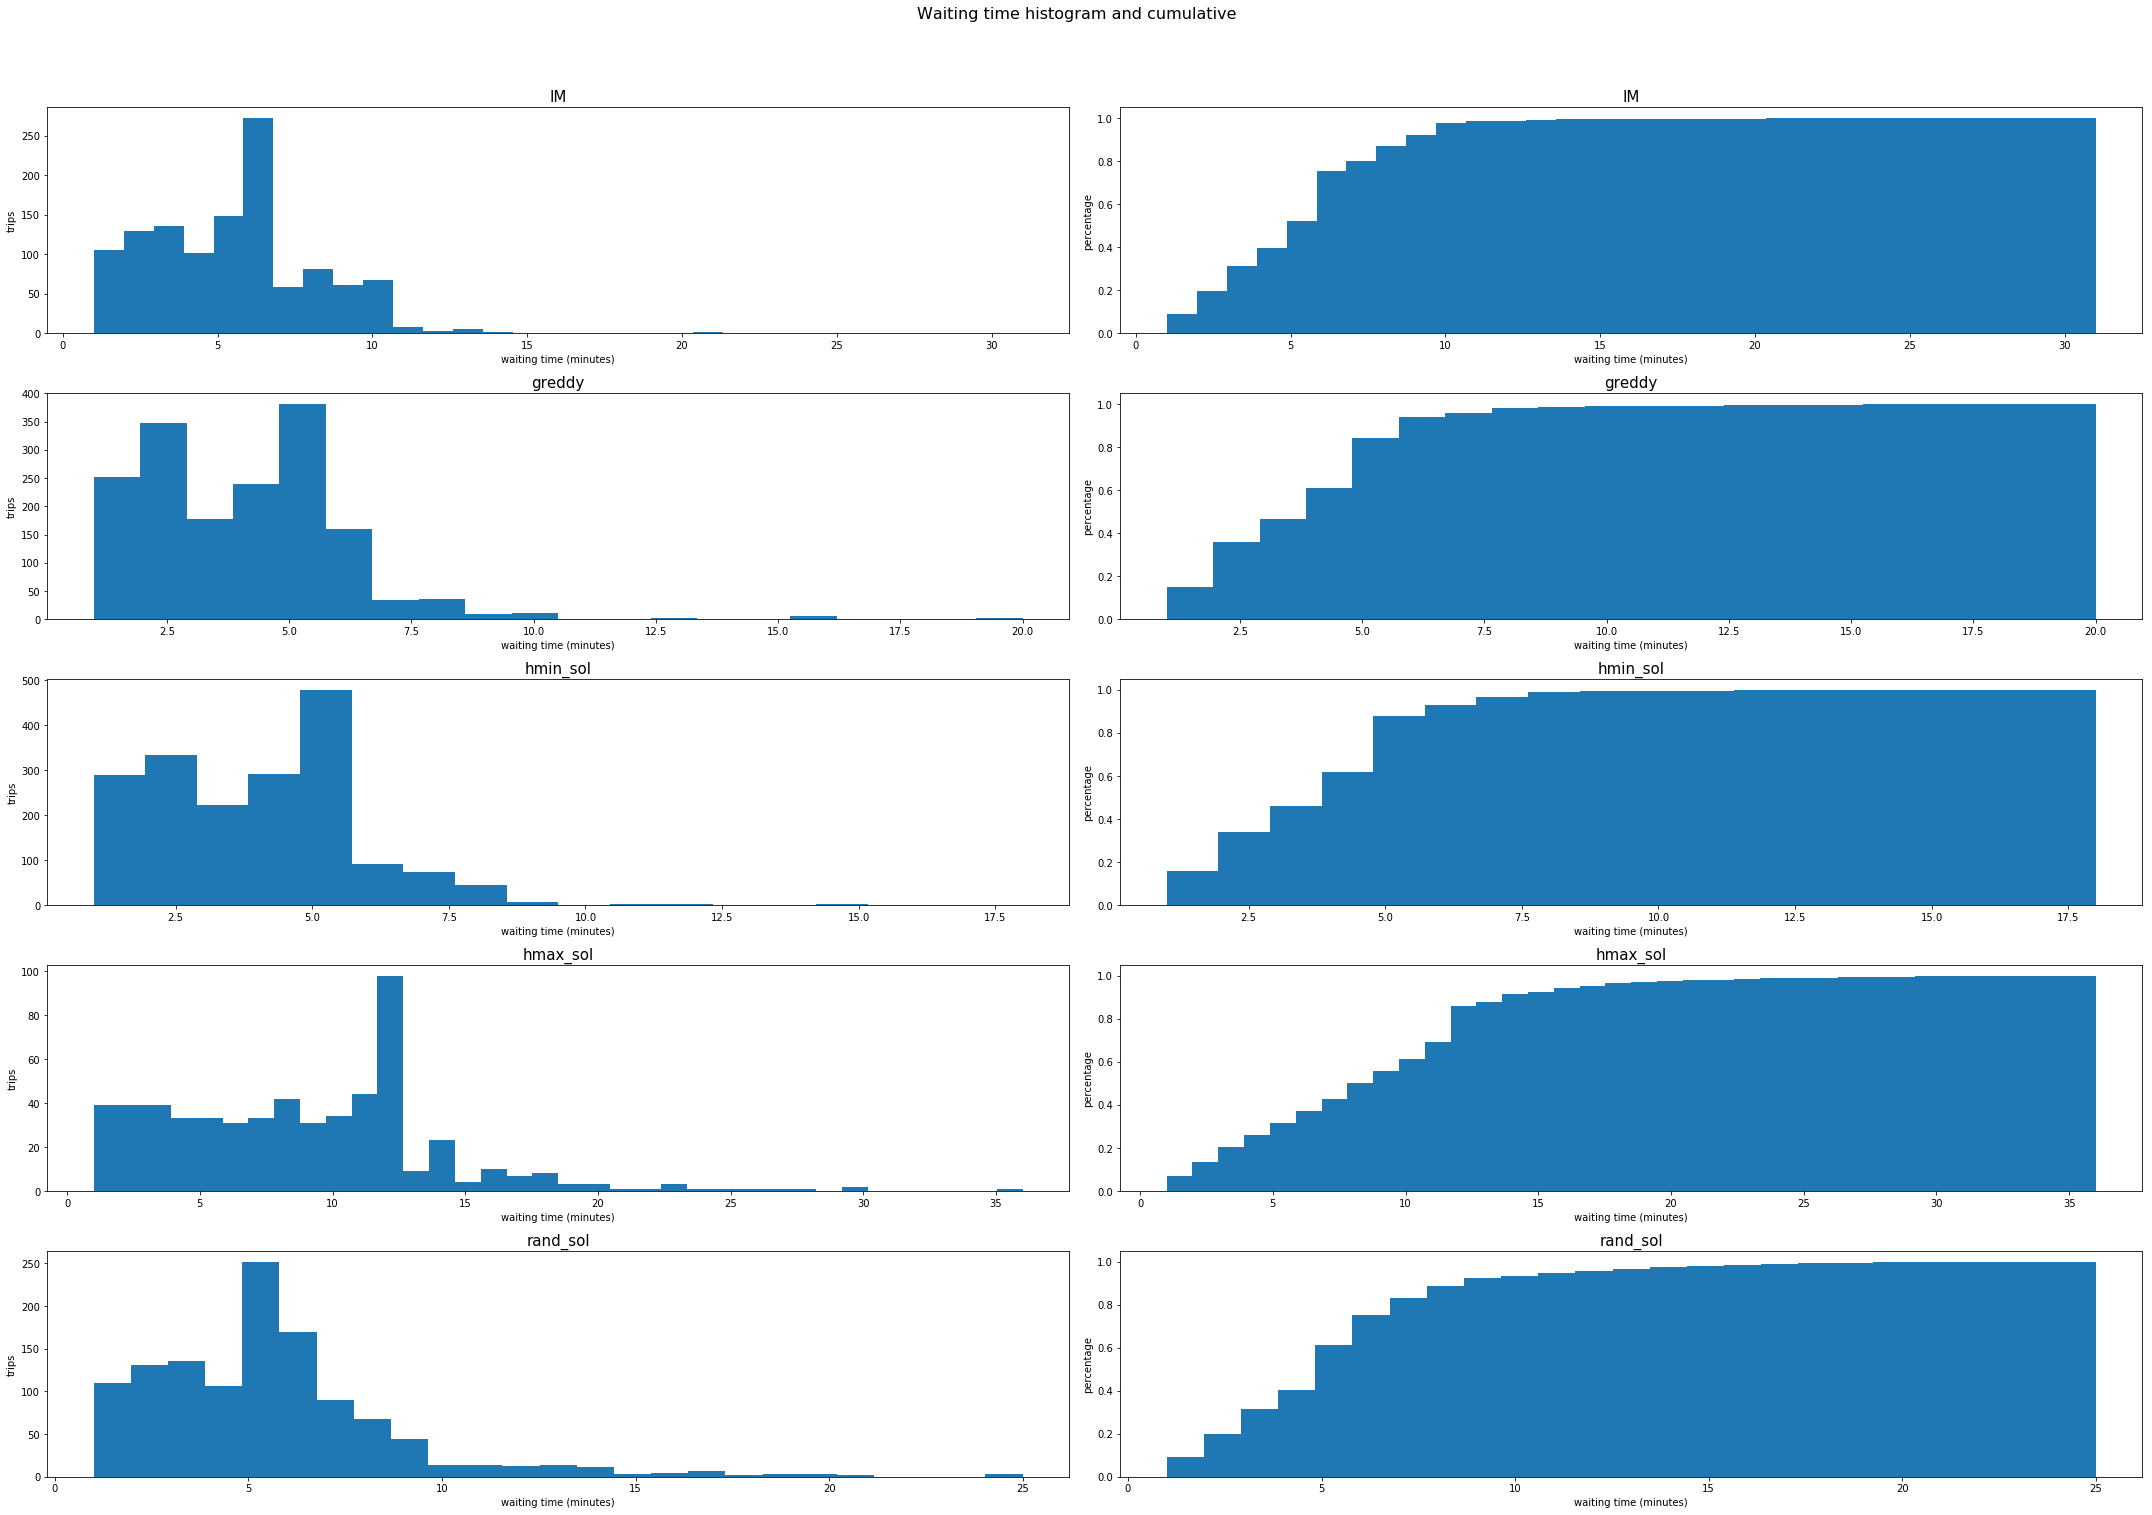

In [65]:
histogram(solutions, solutions_method,  scenario_array[10]['ps_m'],3)

display results (wait per point bar)

In [ ]:
bars(solutions, solutions_method, scenario_array[4]['ps_m'] )
#scenario_array[4]['ps_m'] 

plotting scenarios

In [ ]:
def plot_map(stop_coors,frequecies):
    
    for i in range(len(stop_coors)):
        gdf_bus_stops=gpd.read_file("files/v_uptu_paradas/v_uptu_paradas.shp")
        gdf_streets=gpd.read_file("files/v_mdg_vias/v_mdg_vias.shp")
        bus_schedules_by_stops_aux = bus_schedules_by_stops.copy()
        bus_schedules_by_stops_aux = bus_schedules_by_stops_aux.groupby(['cod_variante','cod_ubic_parada'], 
                                                                        sort=False).max().reset_index()
        #bus_schedules_by_stops_aux = pd.merge(bus_schedules_by_stops_aux, frequecies[i], 
        #                 how='right', left_on=['cod_variante'], right_on=['linea'])
       
        gdf_bus_stops = pd.merge(gdf_bus_stops, bus_schedules_by_stops_aux, 
                         how='right', left_on=['COD_UBIC_P'], right_on=['cod_ubic_parada'])
        geometry = stop_coors[i]['line_1_geometry']
        crs = {'init': 'epsg:4326'}
        syncs1 = gpd.GeoDataFrame(stop_coors, crs=crs, geometry=geometry)
        geometry = stop_coors[i]['line_2_geometry']
        crs = {'init': 'epsg:4326'}
        syncs2 = gpd.GeoDataFrame(stop_coors[i], crs=crs, geometry=geometry)
        fig, ax = plt.subplots(figsize=(15, 10))
        gdf_streets.plot(ax=ax,
                        linewidth=0.4,
                        color="black",
                        label="streets")
        gdf_bus_stops.plot(ax=ax,
                           color="blue",
                        markersize=3,
                      label="bus stops")

        syncs = syncs1.append(syncs2)

        syncs.plot(ax=ax,
                           color="red",
                        markersize=80,
                      label="sync. point")

        plt.legend()
        plt.xlabel("longitude")
        plt.ylabel("latitude")
        plt.rcParams.update({'font.size': 12})

        plt.savefig("figs/paradas_buses.png", bbox_inches='tight')

stop_coors = [
    transfers_all_day_max_tts_coors, 
    transfers_1200_1400_max_tts_coors]

frequecies = [
    frequencies_all_day, 
    frequencies_1200_1400]

plot_map(stop_coors,frequecies)


### Evolutionary ALgoritm Analysis

fitness evolution

In [ ]:
# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
fitness = pd.read_csv('fitness2',sep=';')

In [ ]:
fitness.plot()


In [ ]:
fitness[:].diff(periods=1, axis=0).plot()

In [ ]:
# Friedman test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import friedmanchisquare
# seed the random number generator
seed(1)
# generate three independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 50
data3 = 5 * randn(100) + 52
# compare samples
stat, p = friedmanchisquare(data1, data2, data3)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')